In [1]:
import numpy as np
import palettable
import unyt
import verdict

In [2]:
import galaxy_dive.analyze_data.particle_data as p_data
import galaxy_dive.analyze_data.halo_data as halo_data
import galaxy_dive.utils.constants as constants

# Load Data

In [3]:
sim_data_dir = '/scratch/projects/xsede/GalaxiesOnFIRE/multiphysics/m12i_res7100_mhdcv/output'
halo_data_dir = '/scratch/03057/zhafen/multiphysics/m12i_res7100_mhdcv/halo'
snum = 550
main_halo_id = 0

In [4]:
sim_data_dir = '/scratch/projects/xsede/GalaxiesOnFIRE/metal_diffusion/m12i_res7100/output'
halo_data_dir = '/scratch/03057/zhafen/metal_diffusion/m12i_res7100/halo'
snum = 400
main_halo_id = 0

### Load Halo Data

In [5]:
h_data = halo_data.HaloData(
    data_dir = halo_data_dir,
    mt_kwargs = { 'index': 'snum', 'tag': 'smooth' },
)

In [6]:
data = verdict.Dict( {} )
for ptype in [ 0, 1, 4 ]:
    
    print( 'Loading Particle Type {}'.format( ptype ) )
    
    data[ptype] = p_data.ParticleData(
        sdir = sim_data_dir,
        snum = snum,
        ptype = ptype,
        halo_data_dir = halo_data_dir,
        main_halo_id = main_halo_id,
        mt_index = 'snum',
        ahf_tag = 'smooth',
    )

Loading Particle Type 0
Loading Particle Type 1
Loading Particle Type 4


# Inspect Merger Tree Histories
One of the things we would like to check is that we have the right ID for the main halo.m

(0.0, 15.0)

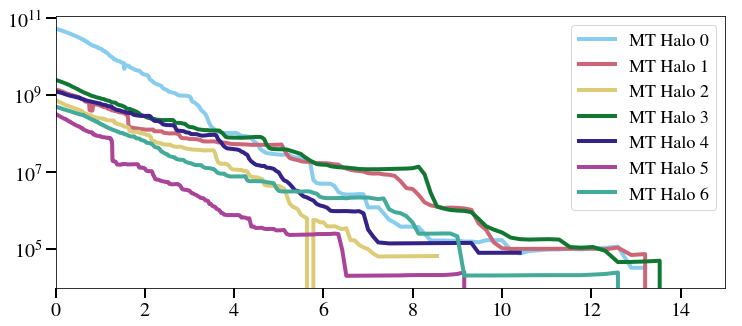

In [7]:
fig = plt.figure( figsize=(12,5), facecolor='w' )
ax = plt.gca()

for mt_id in range( 7 ):
    
    ax.plot(
        h_data.get_mt_data( 'redshift', mt_halo_id=mt_id ),
        h_data.get_mt_data( 'M_star', mt_halo_id=mt_id ),
        linewidth = 4,
        color = palettable.cartocolors.qualitative.Safe_10.mpl_colors[mt_id],
        label = 'MT Halo {}'.format( mt_id ),
    )
    
    ax.legend(prop={'size': 18})
    
ax.set_yscale( 'log' )

ax.set_xlim( 0., 15. )

As we can see, halo ID 0 really does seem to be the main halo.

# Compare Profiles

In [8]:
radii = np.linspace( 0., 1.2*data.r_vir[0], 128 )

## For Particle Data

In [9]:
def get_enclosed_mass( particle_data, radii, ):
    '''Non-optimized but functional way to get enclosed mass'''
    
    print( 'Starting to get enclosed mass' )
    
    m_enclosed = []
    for r in radii:
        
        inside = particle_data.get_data( 'R' ) < r
        
        m_enclosed.append( particle_data.get_data( 'M' )[inside].sum() )
        
    return np.array( m_enclosed )

In [10]:
m_enclosed = data.apply( get_enclosed_mass, radii )

Starting to get enclosed mass
Starting to get enclosed mass
Starting to get enclosed mass


In [11]:
# Convert to solar masses
m_enclosed *= constants.UNITMASS_IN_MSUN

## For Halo Data
Using the reader I set up.

In [12]:
comoving_radii = radii * data[0].data_attrs['hubble'] * ( 1. + data[0].redshift )

In [13]:
m_enc_halo = h_data.get_profile_data( 'M_in_r', snum=snum, r=comoving_radii, mt_halo_id=main_halo_id, )

# Convert out of AHF's M_sun/h units
m_enc_halo /= data[0].data_attrs['hubble']

## Plot the Comparison

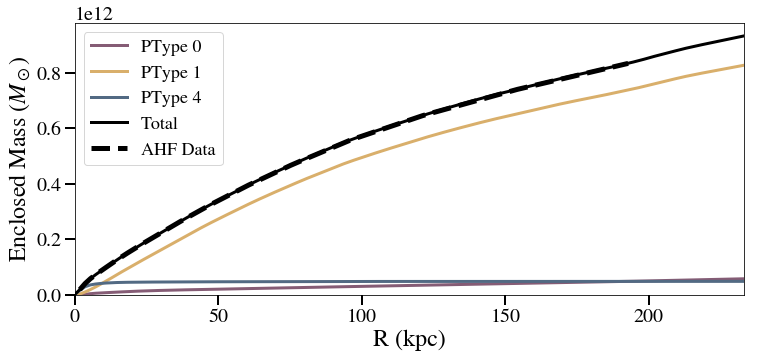

In [14]:
fig = plt.figure( figsize=(12,5), facecolor='w' )
ax = plt.gca()

for ptype, m_enc in m_enclosed.items():
    
    ax.plot(
        radii,
        m_enc,
        linewidth = 3,
        color = palettable.cartocolors.qualitative.Antique_10.mpl_colors[ptype],
        label = 'PType {}'.format( ptype ),
    )
    
ax.plot(
    radii,
    m_enclosed.sum_contents(),
    linewidth = 3,
    color = 'k',
    label = 'Total',
)

ax.plot(
    radii,
    m_enc_halo,
    linewidth = 5,
    color = 'k',
    label = 'AHF Data',
    linestyle = '--'
)

ax.set_xlabel( r'R (kpc)', fontsize=24 )
ax.set_ylabel( r'Enclosed Mass ($M_\odot$)', fontsize=24 )
    
ax.set_xlim( radii[0], radii[-1] )
ax.set_ylim( 0., 1.05*m_enclosed.sum_contents().max() )
    
ax.legend(prop={'size': 18})

# Example of How to Use the Enclosed Mass Function

In [15]:
# Create mock positions for the purpose of the example.
# We'll choose a particle at the virial radius
positions = np.array([
    [ 0., 0., data[0].r_vir ],
])
positions += data[0].origin

In [16]:
h_data = halo_data.HaloData(
    data_dir = halo_data_dir,
    mt_kwargs = { 'index': 'snum', 'tag': 'smooth' },
)

h_data.get_enclosed_mass( 
    positions = positions,
    snum = snum,
    hubble_param = data[0].data_attrs['hubble'],
    mt_halo_id = main_halo_id,
)

array([8.38542806e+11])

In [17]:
data[0].m_vir

866069800569.8007

Its quite close to the virial mass, as we should expect.

# Study the Energy for Particular Snapshots

This is an input for e.g. the dynamical friction, so it's good to understand.

In [18]:
h_a = data[0].data_attrs['hubble'] * ( 1. + data[0].data_attrs['redshift'] )

In [19]:
pro_mvir, v_range = h_data.get_profile_data(                    
    'M_in_r',                                                           
    snum,                                                               
    np.array([ data[0].r_vir ]) * h_a,                               
    mt_halo_id = data[0].main_halo_id,                                     
    return_valid_range = True,                                          
)

In [20]:
# Find the equivalent energy (just interpolation, making using of   
# the monotonic nature of the energy                                
r_co_arr = np.linspace( v_range[0]*1.001, v_range[1]*0.999, 1024 )  
r_arr = r_co_arr / h_a                                              
enclosed_mass = h_data.get_profile_data(                    
    'M_in_r',                                                       
    snum,                                                           
    r_co_arr,                                                       
    mt_halo_id = data[0].main_halo_id                                  
) / data[0].data_attrs['hubble']      
G = unyt.G.to( 'km**2/s**2*kpc/msun' ).value
circ_energy = -0.5 * G * enclosed_mass / r_arr   

In [21]:
e_at_rvir = -0.5 * G * pro_mvir / data[0].data_attrs['hubble'] / data[0].r_vir
e_in = 

r_interp = np.interp( e_at_rvir, circ_energy, r_arr )

In [33]:
e_at_rvir

array([-9280.35915188])

(0.13593751934466963, 194.1576318833561)

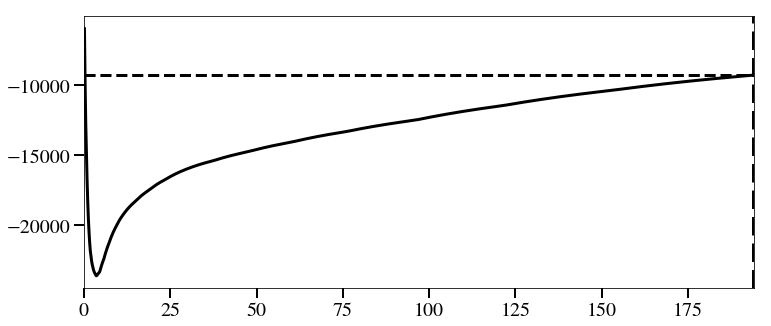

In [32]:
fig = plt.figure( figsize=(12,5), facecolor='w' )
ax = plt.gca()

ax.plot(
    r_arr,
    circ_energy,
    linewidth = 3,
    color = 'k',
)


ax.axhline(
    e_at_rvir,
    linestyle = '--',
    linewidth = 3,
    color = 'k', 
)
ax.axvline(
    r_interp,
#     0.,
#     1.,
    linestyle = '--',
    linewidth = 5,
    color = 'k', 
)
ax.axvline(
    data[0].r_vir,
    linestyle = '-.',
    linewidth = 3,
    color = 'grey', 
)

ax.set_xlim( r_arr[0], r_arr[-1] )